# Business demography of the European Union

## Overview

* This notebook is intended to demonstrate basic techniques of formatting a dataset and gaining simple insights.  The term business demography is used here to cover a group of variables which explain the characteristics and demography of the business population. The creation of new enterprises and the closure of unproductive businesses can be seen as an important contributor to business dynamism. In addition to studying the population of active enterprises, the counts and characteristics of enterprise births and deaths are examined. 

In the following we will apply
* data manipulation using pandas 
* Visualize data using Plotly time-series
* Check correlations between countries
* Visualise with Plotly bar-chart and choropleth




In [11]:
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
import pandas_datareader.data as web

import seaborn as sns
import matplotlib.pyplot as plt

import pycountry
import numpy as np

In [12]:
#UserInfo.tsv
business_demography = pd.read_csv('../datasets/european-business-demography.tsv', delimiter='\t', encoding='utf-8')
#print(list(business_by_demography.columns.values)) #file header
business_demography.columns

Index(['GEO,LEG_FORM,INDIC_SB,NACE_R2\TIME', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015'],
      dtype='object')

### Renaming the lengthy legend

In [13]:
business_demography = business_demography.rename(columns={'GEO,LEG_FORM,INDIC_SB,NACE_R2\TIME':'Countries'})

### Transpose table and generate new vertical index
* Its my personal preference having the growth/death etc. values assigned to each year organized in columns

In [14]:
#Fill empty cells with zeros
business_demography = business_demography.fillna(0)
#Set countries as new dataframe index
business_demography.set_index('Countries',inplace=True)
#Transpose the table
business_demography = business_demography.transpose()

## There are certain flags in the table to indicate special features of the data

### Available flags
* b	break in time series
* c	confidential
* d	definition differs, see metadata
* e	estimated
* f	forecast
* i	see metadata (phased out)
* n	not significant
* p	provisional
* r	revised
* s	Eurostat estimate (phased out)
* u	low reliability
* z	not applicable

It is not recommendable in general to drop the information contained by these flags, but for first exploration purposes it should not do too much harm. The flags can easily remove by filling them all into a list and strip them by looping over this list. 

### Lets remove these flags

In [15]:
flags = ['b', 'c', 'd','e','f','i','n','p','r','s','u','z']

In [16]:
for column in business_demography.columns:  
    column = str(column)
    for flag in flags:
        business_demography[column] = business_demography[column].str.strip(flag)

### Replace the lengthy name of Germany in all availabe columns
1. The lengthy column titles are structered by commas
2. The country name is extracted by using the .split() command with delimiter ','
3. This returns a list of strings where the first element equals the particular country name
4. The name can be replaced

In [17]:
for column in business_demography.columns:  
    column = str(column)
    column_content = column.split(',')[0]
    if 'Germany' in column_content:
        old_german_name = 'Germany (until 1990 former territory of the FRG)'
        new_german_name = 'Germany'
        new_column = column.replace(old_german_name,new_german_name)
        business_demography = business_demography.rename(index=str,columns={column:new_column})

### Replace the colons by zeros and convert strings to numerical values
* The dataset indicates missing data by ':' - lets replace it by zero!
* So far the contained data consists of strings - of course we need numerical values for our exploration.

In [18]:
business_demography = business_demography.replace(':',0)
business_demography =  business_demography.apply(pd.to_numeric, args=('coerce',))
business_demography = business_demography.fillna(0)

### Drop the columns that should contain average data about the EU
* By looking at the raw data you can easily see (of course you can check it as well using pandas) that the columns called 'European Union' contain no data
* Let's drop these columns by using regex, so we get all columns containg 'European Union'!

In [19]:
business_demography.drop(list(business_demography.filter(regex = 'European Union')), axis = 1, inplace = True)

### Drop the years 2006-2008
* Since these years are empty too we can drop them as well!

In [20]:
business_demography = business_demography.drop('2006').drop('2007').drop('2008')

### Last step of preparation: Get all unique country names 
*  it is useful to extract the list of unique countris that are contained in the data

In [21]:
countries_unique = []
for column in business_demography.columns:
    column_content = str(column).split(",")
    countries_unique.append(column_content[0])
countries_unique = list(set(countries_unique))

## Start visualization
* Plot the yearly percentage growth of businesses during 2009 and 2015, sorted by legal forms for Germany

In [22]:

sole = business_demography['Germany,Sole proprietorship,Net business population growth - percentage,Business economy except activities of holding companies']    
total = business_demography['Germany,Total,Net business population growth - percentage,Business economy except activities of holding companies']
partnership = business_demography['Germany,Partnership, co-operatives, associations, etc.,Net business population growth - percentage,Business economy except activities of holding companies']
limiteds = business_demography['Germany,Limited liability enterprise,Net business population growth - percentage,Business economy except activities of holding companies']



sole_proprietorship = go.Scatter(x=sole.index, y=sole, name='Sole proprietorship')
total_growth = go.Scatter(x=total.index, y=total, name='Total growth')
partnerships = go.Scatter(x=partnership.index, y=partnership, name='Partnerships & Associates')
limiteds = go.Scatter(x=limiteds.index, y=limiteds, name='Limited liability')

data = [sole_proprietorship,total_growth,partnerships,limiteds]

layout = dict(
    title = "Growth comparison of different legal forms in Germany",
    xaxis = dict(
        range = ['2009','2015'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

### The growth of each legalform during the years 2009-2015
* Calculate the growth rate of each legal form, averaged over all countries
* From the plot it can be seen that enterprises with limited liability are the dominating source of the total growth of the business population

In [23]:
#Addin new column to dataframe which contains the average of the particular row's values
business_demography['Sole proprietorship growth'] = business_demography.filter(regex='Sole proprietorship,Net business population growth', axis=1).mean(axis=1)
business_demography['Total growth in the EU'] = business_demography.filter(regex='Total,Net business population growth', axis=1).mean(axis=1)
business_demography['Partnership growth'] = business_demography.filter(regex='Partnership, co-operatives, associations, etc.,Net business population growth', axis=1).mean(axis=1)
business_demography['Limiteds growth'] = business_demography.filter(regex='Limited liability enterprise,Net business population growth', axis=1).mean(axis=1)



sole_proprietorship = go.Scatter(x=business_demography.index, y=business_demography['Sole proprietorship growth'], name='Sole proprietorship')
total_growth = go.Scatter(x=business_demography.index, y=business_demography['Total growth in the EU'], name='Total growth')
partnerships = go.Scatter(x=business_demography.index, y=business_demography['Partnership growth'], name='Partnerships & Associates')
limiteds = go.Scatter(x=business_demography.index, y=business_demography['Limiteds growth'], name='Limited liability')

data = [sole_proprietorship,total_growth,partnerships,limiteds]

layout = dict(
    title = "Growth comparison of different legal forms across the EU",
    xaxis = dict(
        range = ['2009','2015'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

### Correlations between growth of different legal forms
Plot the correlations of the average 
* Sole proprietorship growth
* Partnership growth
* Limiteds growth
* Total growth in the EU

As can be seen from the plot above, the percentage growth of the enterprises with limited enterprise ist strongly correlated with the total growth in the European Union. The growth of the partnerships, associates etc. is decoupled from the growth of the companies with limited liability. 

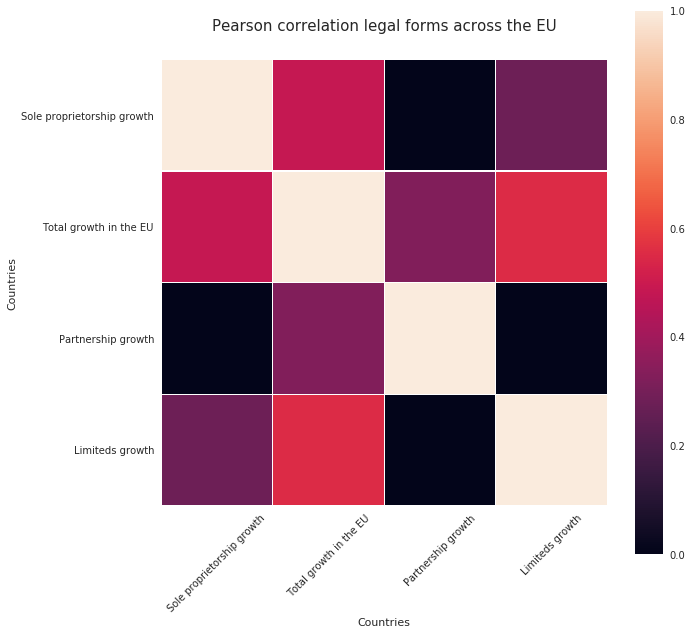

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

eu_growth_rates = business_demography.iloc[:,-4:]

plt.figure(figsize=(10,10))
plt.title('Pearson correlation legal forms across the EU', y=1.05, size=15)
plot = sns.heatmap(eu_growth_rates.corr(), xticklabels=eu_growth_rates.columns, yticklabels=eu_growth_rates.columns,  linewidths=0.1,vmax=1.0,vmin=0, square=True, linecolor='white')
#plot.set_xticklabels(plot.get_xticklabels(),rotation=30)
#plot.set_ylabel('')
#plot.set_xlabel('')
plt.setp(plot.get_xticklabels(), rotation=45)
plt.setp(plot.get_yticklabels(), rotation=0)

plt.show()


## Look at the average total net growth of businesses in the EU between 2009 and 2015

* Calculate the average net growth of businesse for each country in the period of measurement 2009-2015
* To visualize the data on a choropleth map the standard country codes are attached to each dataframe entry 
    * Country codes consist of two or three letters: alpha2 and alpha3  --> Read about [alpha3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3)
    * It seems that the plotly choropleth only accepts alpha3 (Probably i have overlooked this in the reference)
    
In the first step we will create a new dataframe where we
* we choose the columns containing 'Total,Net business population growth' 
* map the country name to its corresponding country code
* Calculate the mean of the total growth during the period of measurement 2009 - 2015

In [25]:
from pycountry import *  
mean_growth = []
country_names = []
country_codes = []

mapping = {country.name: country.alpha3 for country in pycountry.countries}

for column in business_demography.columns:
    if 'Total,Net business population growth' in column:
        new_column_name = column.split(',')[0]
        #country_names.append(new_column_name)
        mean_growth.append(business_demography[column].mean())
        country_codes.append((new_column_name, mapping.get(new_column_name, 'No country found')))

mean_growth_country = pd.DataFrame(np.column_stack([country_codes,mean_growth]), columns=['Country', 'Code', 'Mean growth'])

In [26]:
mean_growth_country

,Country,Code,Mean growth
0,Belgium,BEL,3.0828571428571423
1,Bulgaria,BGR,3.4728571428571433
2,Czech Republic,CZE,2.974285714285714
3,Denmark,DNK,-0.1599999999999999
4,Germany,DEU,-0.8514285714285713
5,Estonia,EST,1.5400000000000003
6,Ireland,IRL,-0.6385714285714286
7,Greece,GRC,-0.2542857142857143
8,Spain,ESP,-1.4257142857142855
9,France,FRA,3.4942857142857138


## Now we can plot `mean_growth_country` as a Plotly bar diagram.

In [27]:
data = [go.Bar(
            x = mean_growth_country['Country'],
            y = mean_growth_country['Mean growth']
        
    )]
layout = go.Layout(
    title='Business growth between 2009 and 2015',
)

fig = go.Figure(layout=layout)
py.iplot(data, filename='basic-bar')

## Because we have the correct country codes we can also show the same information as a choropleth map using Plotly

In [28]:

data = [ dict(
        type = 'choropleth',
        locations = mean_growth_country['Code'],
        z = mean_growth_country['Mean growth'],
        text = mean_growth_country['Country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '%',
            title = 'Average growth of business population'),
      ) ]

layout = dict(
    title = 'Average growth of business population in the years 2009-2015',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

### Conclusion
The dominating sources for the total growth of the business population are France, the Benelux states as well as a number eastern european Countries. The explored data was taken during 2009 and 2015. A dominating and stable source for growth of the business population are the enterprises with limited liability .

/home/chris/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



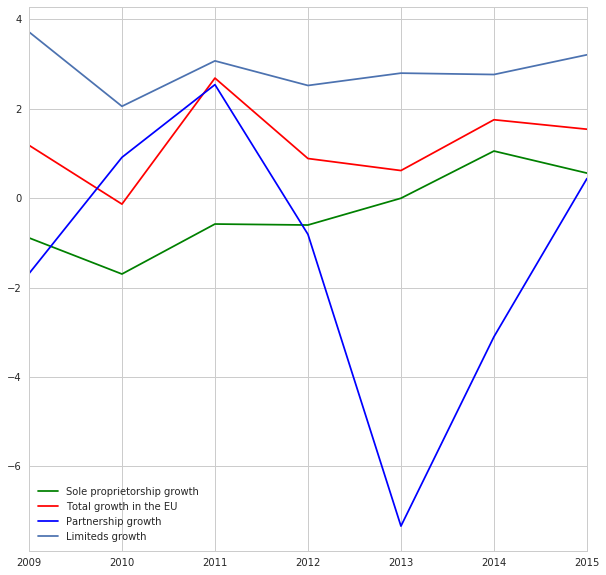

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
sns.set(style="whitegrid")
#sns.set_style({'font.family': 'Times New Roman'})

sole = 'Sole proprietorship growth'
total = 'Total growth in the EU'
partner = 'Partnership growth'
limit = 'Limiteds growth'
business_demography[sole] = business_demography.filter(regex='Sole proprietorship,Net business population growth', axis=1).mean(axis=1)
business_demography[total] = business_demography.filter(regex='Total,Net business population growth', axis=1).mean(axis=1)
business_demography[partner] = business_demography.filter(regex='Partnership, co-operatives, associations, etc.,Net business population growth', axis=1).mean(axis=1)
business_demography[limit] = business_demography.filter(regex='Limited liability enterprise,Net business population growth', axis=1).mean(axis=1)


# Load the long-form example gammas dataset
gammas = sns.load_dataset("gammas")

plt.figure(figsize=(10,10))
# Plot the response with standard error
sns.tsplot(data=business_demography[sole], time=business_demography.index ,condition=sole, legend=True, color='green' )
sns.tsplot(data=business_demography[total], time=business_demography.index ,condition=total, legend=True, color='red' )
sns.tsplot(data=business_demography[partner], time=business_demography.index ,condition=partner, legend=True, color='blue' )
sns.tsplot(data=business_demography[limit], time=business_demography.index ,condition=limit, legend=True )

plt.show()

In [40]:
business_demography.iloc[:,-4:]

Countries,Sole proprietorship growth,Total growth in the EU,Partnership growth,Limiteds growth
2009,-0.887813,1.184687,-1.688750,3.720937
2010,-1.697188,-0.132813,0.913750,2.056250
2011,-0.578437,2.687500,2.540938,3.072812
2012,-0.600625,0.887500,-0.809063,2.522187
2013,-0.001250,0.618437,-7.338125,2.798438
2014,1.055000,1.755312,-3.100938,2.767500
2015,0.561250,1.543438,0.439375,3.208750


In [33]:
gammas

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992
5,0.0,IPS,5,-0.073709
6,0.0,IPS,6,3.542734
7,0.0,IPS,7,0.080169
8,0.0,IPS,8,1.547083
9,0.0,IPS,9,2.827153
